In [347]:
###################################
# Importing libraries and modules #
###################################

# Data Wrangling
import pandas as pd
import numpy as np
import collections
from scipy.stats import norm
import pandas_profiling

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import chart_studio.tools as tls
import chart_studio
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly_api_key import plotly_api_key

# Machine learning libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer #applies a power transformation to each feature to make the data more Gaussian-like.
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix


# Library to balance targets
from imblearn.over_sampling import SMOTE
from collections import Counter

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [228]:
# Downgrading matplotlib because of a bug resulting in truncated images
import matplotlib
matplotlib.__version__

'3.1.0'

In [229]:
chart_studio.tools.set_credentials_file(username='rogerlefort', api_key=plotly_api_key)

In [230]:
###################################
#        Data Preprocessing       #
###################################

In [362]:
# Opening dataset
play_by_play = pd.read_csv('resources/final_table_for_model_build.csv')
play_by_play.head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,play_type,desc,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
3,56.0,1,1707.0,3507.0,4.0,8,3.0,3.0,0.0,punt,Sunny,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0


In [363]:
play_by_play.play_type.value_counts()

pass          186363
run           132668
no_play        24134
punt           23937
field_goal      9790
qb_kneel        3757
qb_spike         690
Name: play_type, dtype: int64

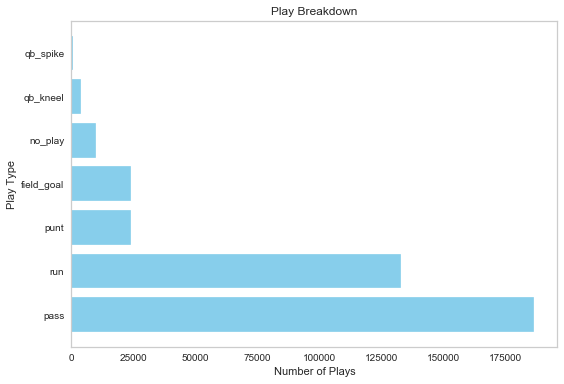

In [364]:
# Plotting play types
x_pos = play_by_play.play_type.unique()
y_values = play_by_play.play_type.value_counts()
plt.ylabel('Play Type')
plt.xlabel('Number of Plays')
plt.title('Play Breakdown')
plt.grid(False)
plt.barh(x_pos, y_values, color='SkyBlue')
plt.savefig('plots/play_breakdown_pre.png', dpi=600)
plt.tight_layout()
plt.show()

In [234]:
play_breakdown_before = go.Figure(data=[go.Pie(labels=x_pos, values=y_values, hole=.5)])

play_breakdown_before.update_layout(
    title_text="Play Breakdown - All Plays",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)
play_breakdown_before.update_layout(
    legend=go.layout.Legend(
        x=-1,
        y=1,
        traceorder="normal",
        font=dict(
            family="Avenir",
            size=18,
            color="black"
        ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
    )
)
play_breakdown_before.show(renderer="iframe", width=500, height=500)
py.plot(play_breakdown_before, filename = 'play_breakdown_before', auto_open=False)

'https://plot.ly/~rogerlefort/4/'

For our analysis, we'll only consider pass and run plays

In [9]:
only_productive_plays = play_by_play[(play_by_play.play_type == 'pass') | (play_by_play.play_type == 'run')]
# Removing duplicates
only_productive_plays.drop_duplicates().head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,play_type,desc,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
5,98.0,1,1660.0,3460.0,2.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0


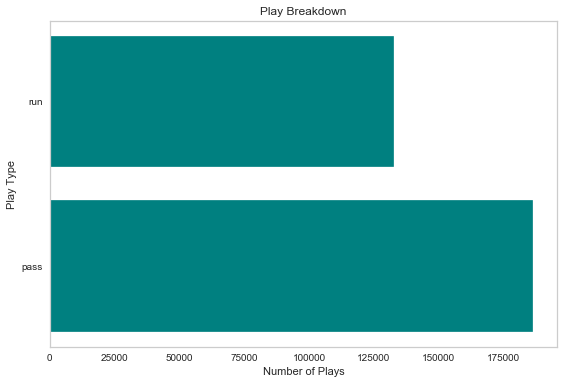

In [365]:
# Plotting play types with only passes and runs
x_pos = only_productive_plays.play_type.unique()
y_values = only_productive_plays.play_type.value_counts()
plt.ylabel('Play Type')
plt.xlabel('Number of Plays')
plt.title('Play Breakdown')
plt.grid(False)
plt.barh(x_pos, y_values, color='teal')
plt.tight_layout()
plt.savefig('plots/play_breakdown_post.png', dpi=600)
plt.show()

In [225]:
play_breakdown_after = go.Figure(data=[go.Pie(labels=x_pos, values=y_values, hole=.5)])

play_breakdown_after.update_layout(
    title_text="Play Breakdown - Runs and Passes",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)
play_breakdown_after.update_layout(
    legend=go.layout.Legend(
        x=-1,
        y=1,
        traceorder="normal",
        font=dict(
            family="Avenir",
            size=18,
            color="black"
        ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
    )
)
play_breakdown_after.show(renderer="iframe", width=500, height=500)
py.plot(play_breakdown_after, filename = 'play_breakdown_after', auto_open=False)

'https://plot.ly/~rogerlefort/59/'

In [12]:
# Selecting features
X = only_productive_plays.drop(columns=['play_type', 'desc'])
X.head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0
5,98.0,1,1660.0,3460.0,2.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0


In [194]:
# Selecting target
y = only_productive_plays.play_type
y.head()

0    pass
1     run
2    pass
4     run
5    pass
Name: play_type, dtype: object

In [195]:
print(X.shape)
print(y.shape)

(319031, 15)
(319031,)


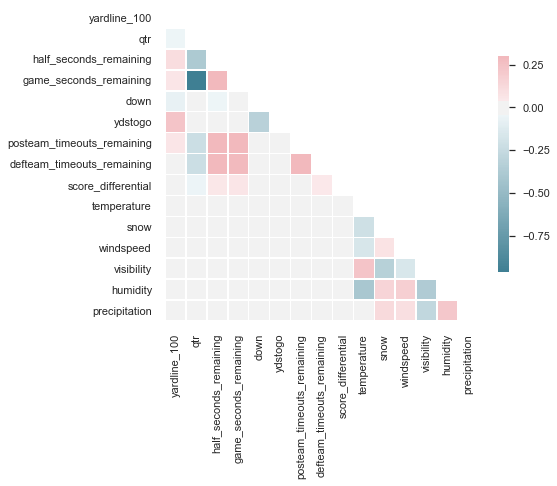

In [366]:
sns.set(style="white")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig('plots/correlation_matrix.png', dpi=600, transparent=True)

In [18]:
########################################
#  FEATURE ENGINEERING AND SELECTION   #
########################################

In [19]:
##### Run only once as it takes a long time to process #########
# Comment code below to run 
#--------------------------------------------------------------#

# # With Pandas profiling we can get a complete profile of all the features
# feature_profile = X.profile_report()
# feature_profile.to_file(output_file="feature_profile_preprocessing.html")
# feature_profile

# # Checking for highly correlated feature_names
# rejected_variables = feature_profile.get_rejected_variables(threshold=0.8)
# rejected_variables

Our dataset does not contain any correlated features (Threshold=0.8)

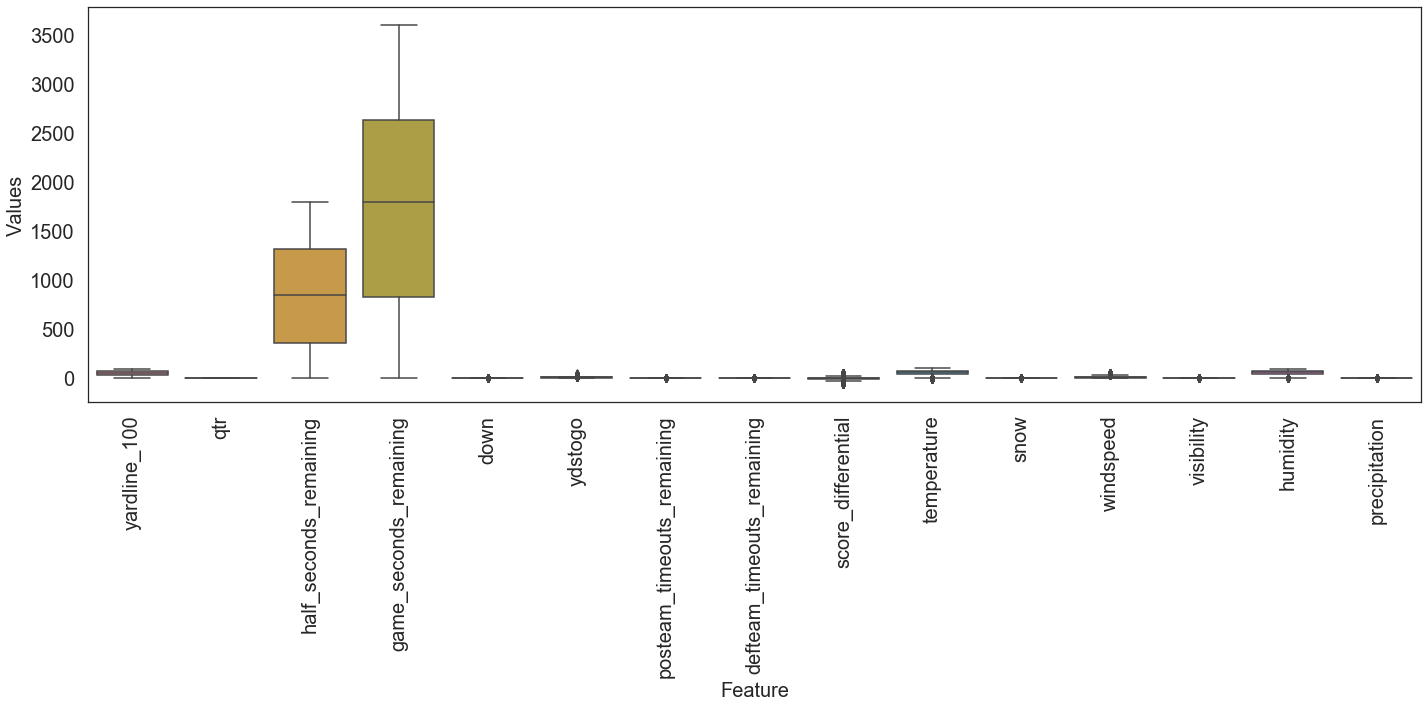

In [16]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X))
fig.set_size_inches(20, 10)
ax.set_ylabel('Values', fontsize=20)
ax.set_xlabel('Feature', fontsize=20)
plt.tick_params(labelsize=20)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('plots/box_plot.png', dpi=600)
plt.show()

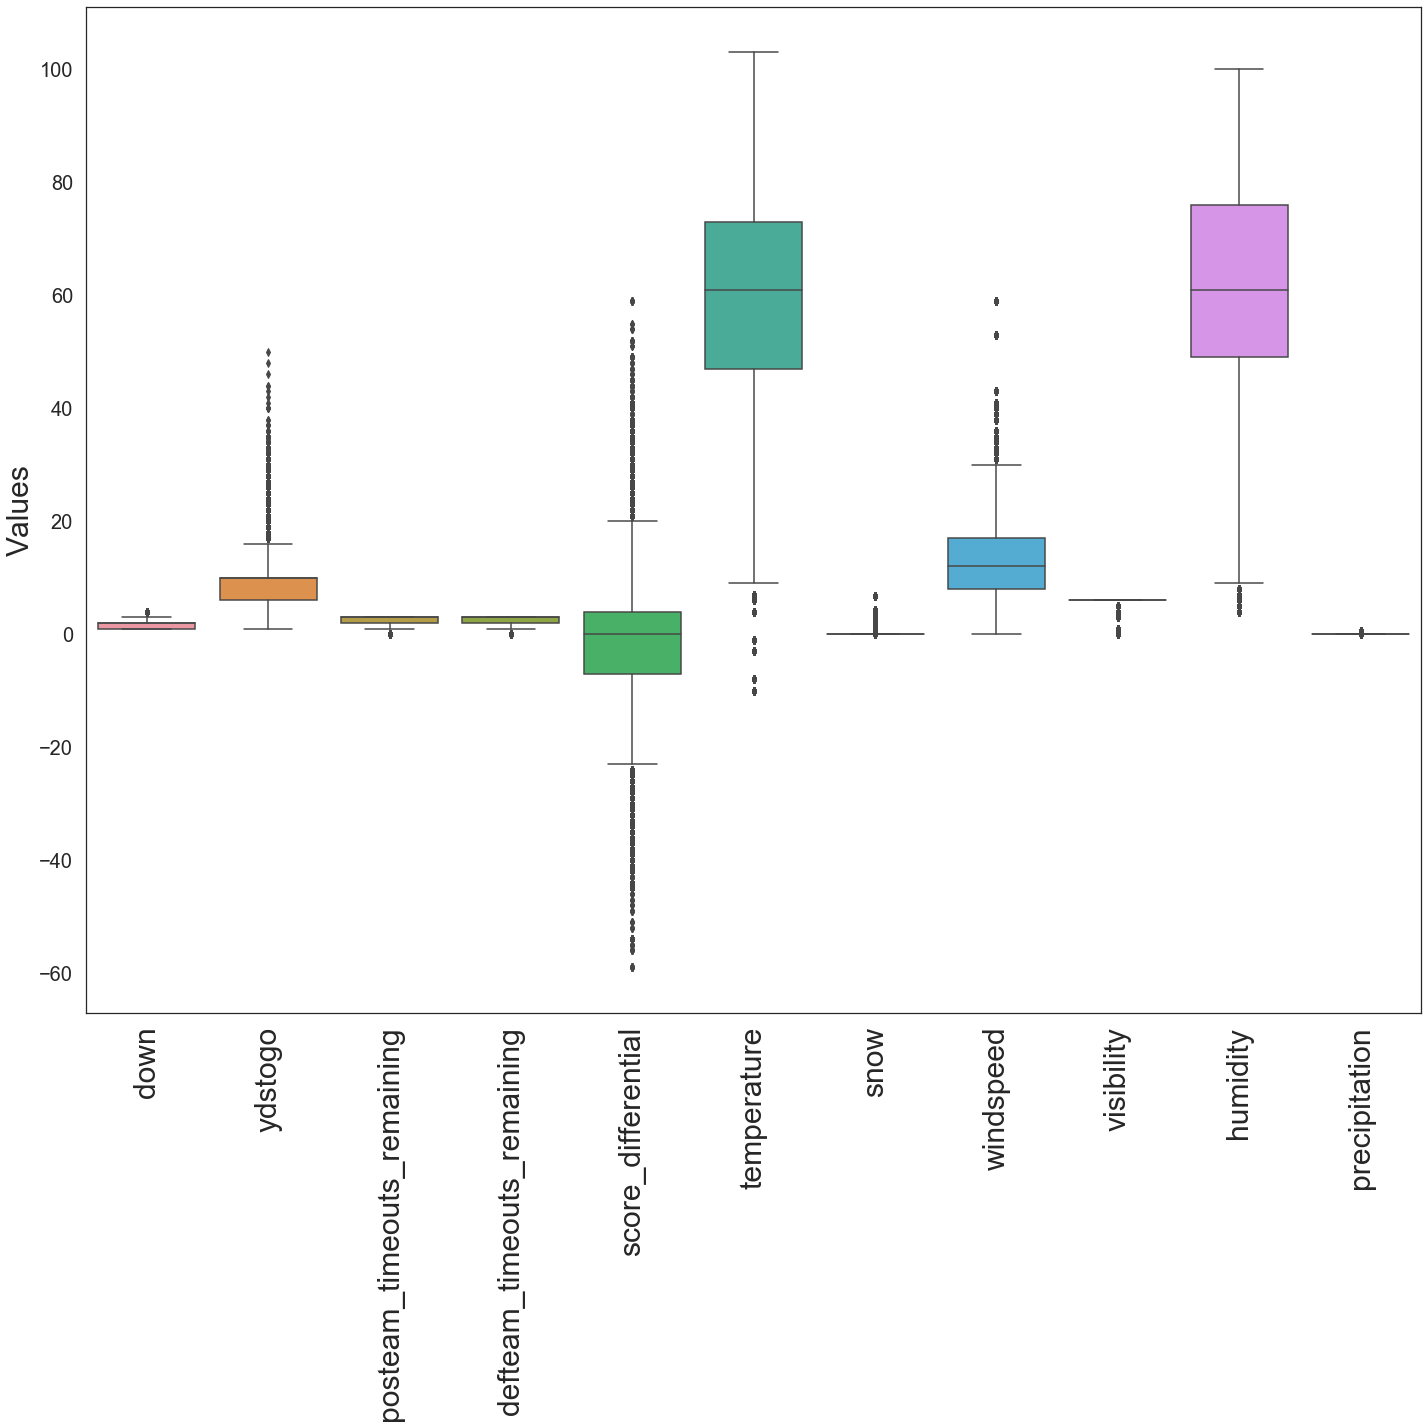

In [23]:
X_outliers = X.drop(columns=['half_seconds_remaining', 'game_seconds_remaining', 'yardline_100', 'qtr'])
fig, ax = plt.subplots()
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X_outliers))
fig.set_size_inches(20, 20)
ax.set_ylabel('Values', fontsize=30)
ax.set_xlabel('', fontsize=30)
plt.tick_params(labelsize=20)
plt.xticks(rotation='vertical', fontsize=30)
plt.tight_layout()
plt.savefig('plots/box_plot_only_outliers.png', dpi=600, transparent=True)
plt.show()

In [252]:
X.loc[X.score_differential == 59]

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,temperature,snow,windspeed,visibility,humidity,precipitation
12738,43.0,4,858.0,858.0,1.0,10,2.0,2.0,59.0,39,0.0,33,3,98,0.3
12740,19.0,4,791.0,791.0,1.0,15,2.0,2.0,59.0,39,0.0,33,3,98,0.3
12741,17.0,4,750.0,750.0,2.0,13,2.0,2.0,59.0,39,0.0,33,3,98,0.3
12742,11.0,4,704.0,704.0,3.0,7,2.0,2.0,59.0,39,0.0,33,3,98,0.3
12743,11.0,4,700.0,700.0,4.0,7,2.0,2.0,59.0,39,0.0,33,3,98,0.3
12752,70.0,4,416.0,416.0,1.0,10,2.0,1.0,59.0,39,0.0,33,3,98,0.3
12753,65.0,4,380.0,380.0,2.0,5,2.0,1.0,59.0,39,0.0,33,3,98,0.3
12754,50.0,4,343.0,343.0,1.0,10,2.0,1.0,59.0,39,0.0,33,3,98,0.3
12755,50.0,4,340.0,340.0,2.0,10,2.0,1.0,59.0,39,0.0,33,3,98,0.3
12756,46.0,4,297.0,297.0,3.0,6,2.0,1.0,59.0,39,0.0,33,3,98,0.3


In [69]:
#### Code below produces plotly box plots (large output file --run only for visualization)


# Comment code below to run 
#--------------------------------------------------------------#

# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# box_plot = go.Figure()
# columns = X.columns
# for col in columns:

#     y = X[col]
#     box_plot.add_trace(go.Box(y=y, name=col))


# box_plot.show(renderer="iframe", width=800, height=500)
# # py.plot(box_plot, filename = 'box_plot', auto_open=True)

A number of features contain outliers. All features will be transformed to account for outliers using power_transform

In [49]:
####################################
#     INITIAL MODEL EVALUATION     #
####################################

In [196]:
# Scaling data using powertransformer to minimize the effcts of outliers
pt = PowerTransformer()
pt.fit(X)
X_transformed = pt.transform(X)

In [197]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=42, stratify=y)

In [292]:
import xgboost as xgb
XGB_model = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
XGB_model.fit(X_train, y_train)
XGB_model.score(X_test ,y_test)

In [320]:

models = [
    XGB_model,
    AdaBoostClassifier(random_state=1),
    SGDClassifier(max_iter=100, tol=1e-3), 
    KNeighborsClassifier(),
    LogisticRegression(solver='newton-cg'), 
    LogisticRegressionCV(cv=3),
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=200),
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=300)
]

In [321]:
classifiers = ['XGBoost', 
               'AdaBoost', 
              'Stochastic Gradient Descent', 
              'K-Nearest Neighbor', 
              'Logistic Regression', 
               'Logistic RegressionCV', 
               'Bagging', 
               'Extra Tree', 
               'Decision Tree', 
               'Random Forrest']

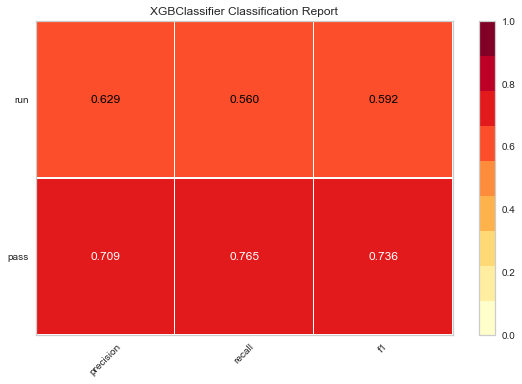

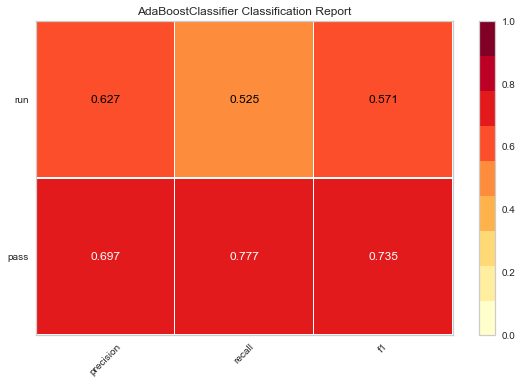

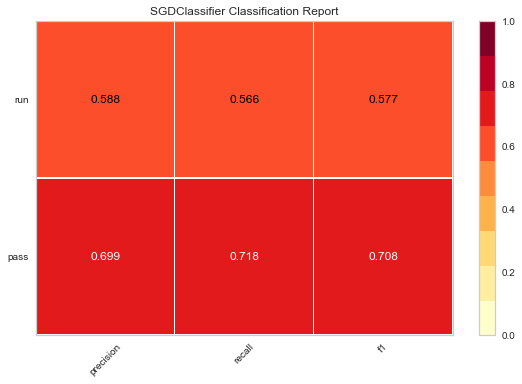

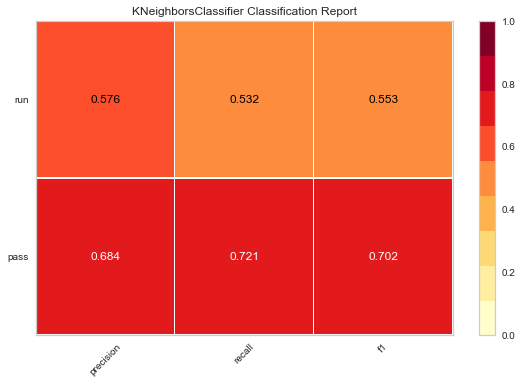

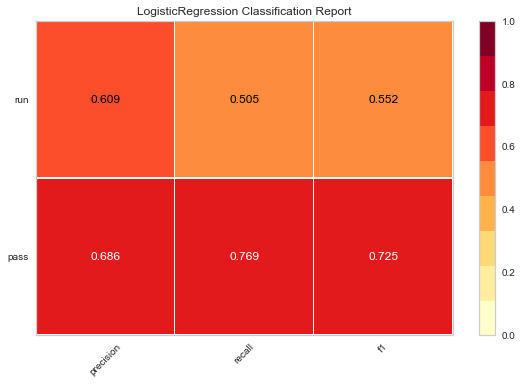

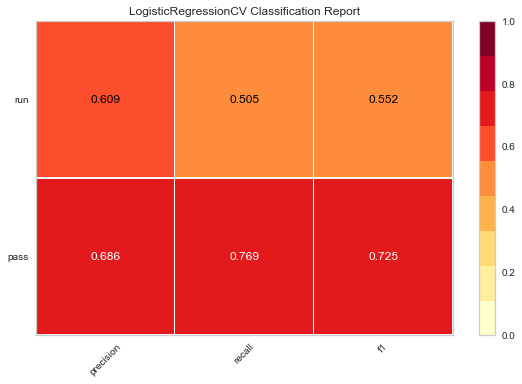

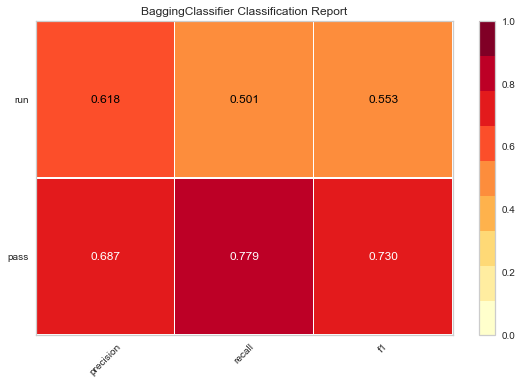

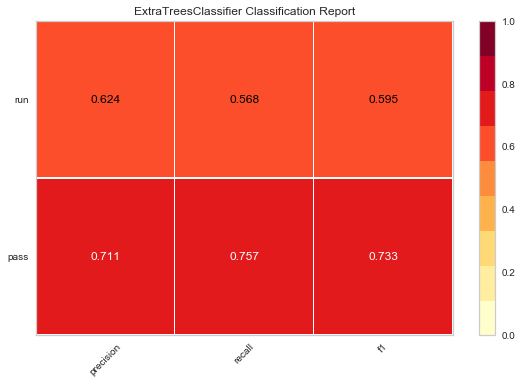

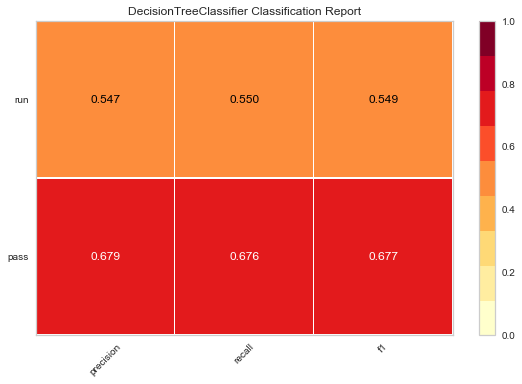

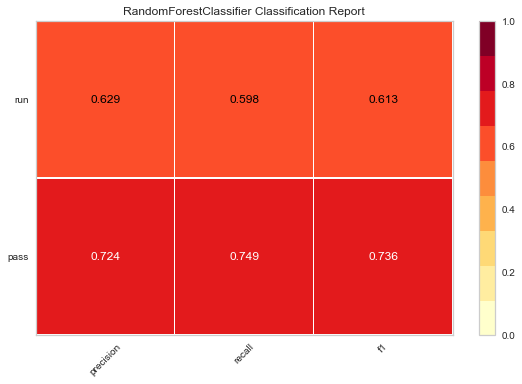

In [322]:
model_accuracy =[]
for estimator in models:
    model = ClassificationReport(estimator)
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    accuracy = model.score_
    model_accuracy.append(accuracy) 
    model.show()

In [323]:
model_accuracy

[0.6795180420772838,
 0.6723964994107174,
 0.6545299531081522,
 0.6425813084580857,
 0.6591689861832042,
 0.6591564482559743,
 0.6634569572958199,
 0.6783520148449058,
 0.6237618796860503,
 0.6864891296170917]

In [324]:
model_df = pd.DataFrame()
model_df['model'] = classifiers
model_df['testing_accuracy'] = model_accuracy

In [325]:
model_df.sort_values('testing_accuracy', ascending=False, inplace=True)

In [326]:
model_df.testing_accuracy

9    0.686489
0    0.679518
7    0.678352
1    0.672396
6    0.663457
4    0.659169
5    0.659156
2    0.654530
3    0.642581
8    0.623762
Name: testing_accuracy, dtype: float64

In [329]:
model_accuracy = go.Figure(data=go.Bar(
            x=model_df.model,
            y=model_df.testing_accuracy,
            marker=dict(
                color='rgba(8,80,111,100)'),
            orientation='v')
               )

model_accuracy.update_layout(
#     title_text="Testing Accuracy",
    yaxis_title="Accuracy Score",
    paper_bgcolor = 'rgba(0,0,0,0)',
    plot_bgcolor = 'rgba(0,0,0,0)'
)

model_accuracy.show(renderer="iframe", width=1000, height=800)
py.plot(model_accuracy, filename = 'model_accuracy', auto_open=True)

'https://plot.ly/~rogerlefort/93/'

In [253]:
models

[AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=1),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
               power_t=0.5, random_state=None, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_st

In [328]:
model_df.to_json('resources/model_accuracy.json', orient='records')

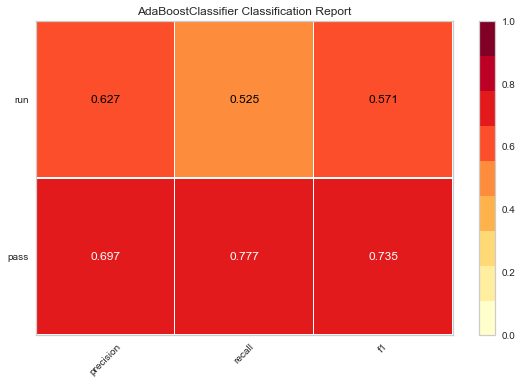

In [254]:
# AdaBoost
AdaB = ClassificationReport(AdaBoostClassifier(random_state=1))
AdaB.fit(X_train, y_train)
AdaB.score(X_test, y_test)
AdaB.show(outpath='model_reports/AdaB.svg')

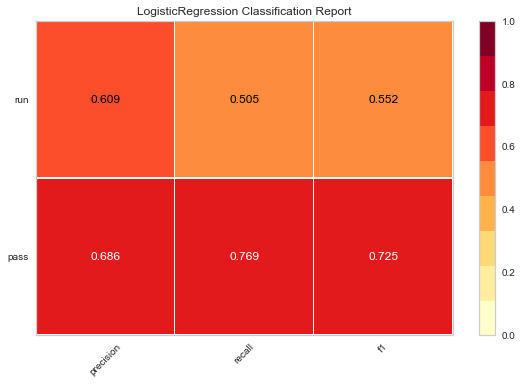

In [258]:
# Logistic regression
logreg = ClassificationReport(LogisticRegression(solver='newton-cg'))
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)
logreg.show(outpath='model_reports/logreg.svg')

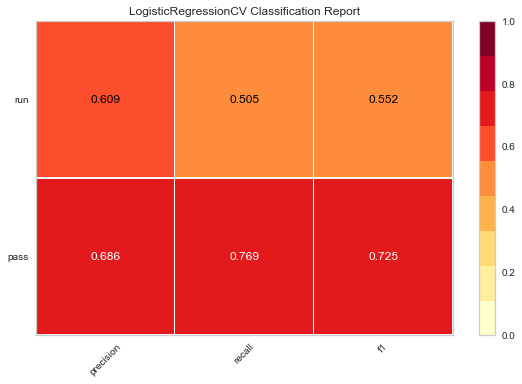

In [261]:
# Logistic regressionCV
logregCV = ClassificationReport(LogisticRegressionCV(cv=3))
logregCV.fit(X_train, y_train)
logregCV.score(X_test, y_test)
logregCV.show(outpath='model_reports/logregCV.svg')

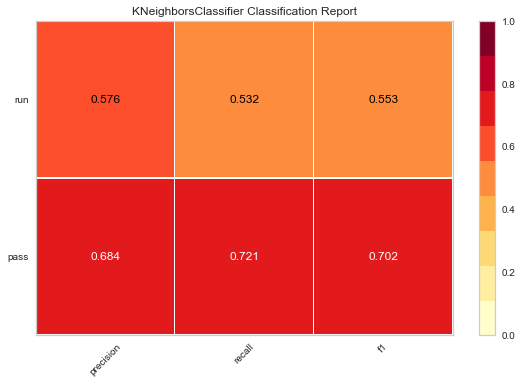

In [262]:
# K Nearest neighbor
knn = ClassificationReport(KNeighborsClassifier())
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
knn.show(outpath='model_reports/knn.svg')

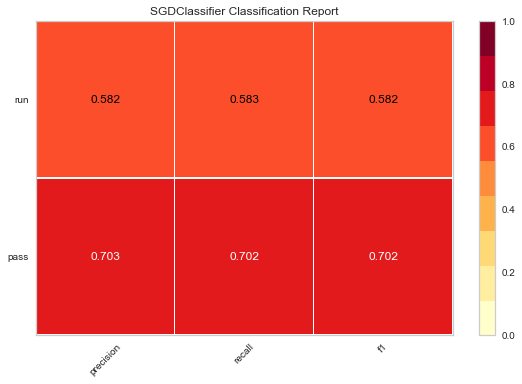

In [263]:
# SDG
sdg = ClassificationReport(SGDClassifier(max_iter=100, tol=1e-3))
sdg.fit(X_train, y_train)
sdg.score(X_test, y_test)
sdg.show(outpath='model_reports/sdg.svg')

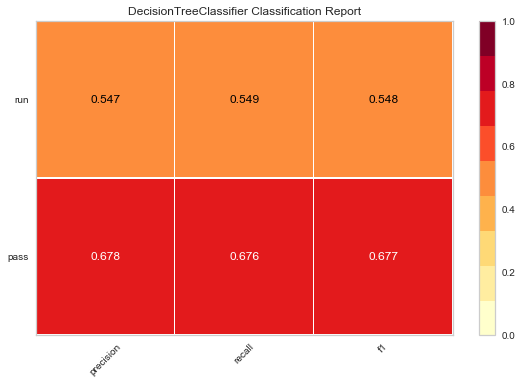

In [264]:
# Decision Tree
tree = ClassificationReport(tree.DecisionTreeClassifier())
tree.fit(X_train, y_train)
tree.score(X_test, y_test)
tree.show(outpath='model_reports/tree.svg')

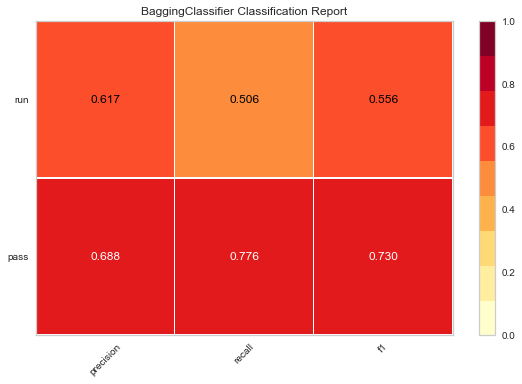

In [265]:
# Bagging
bag = ClassificationReport(BaggingClassifier())
bag.fit(X_train, y_train)
bag.score(X_test, y_test)
bag.show(outpath='model_reports/bag.svg')

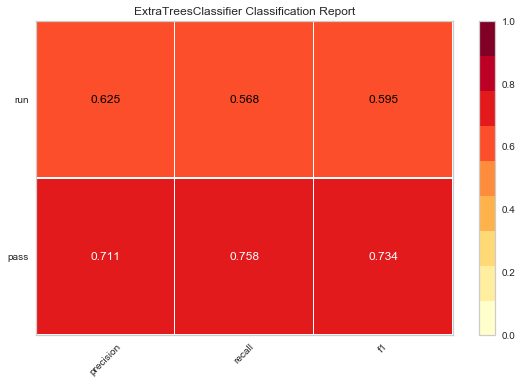

In [266]:
# Extra tree
extree = ClassificationReport(ExtraTreesClassifier(n_estimators=200))
extree.fit(X_train, y_train)
extree.score(X_test, y_test)
extree.show(outpath='model_reports/extree.svg')

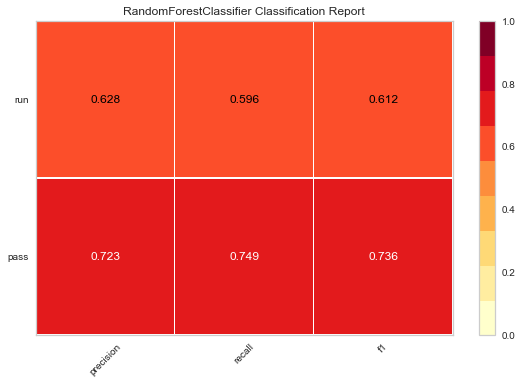

In [267]:
# Random Forrest
forrest = ClassificationReport(RandomForestClassifier(n_estimators=300))
forrest.fit(X_train, y_train)
forrest.score(X_test, y_test)
forrest.show(outpath='model_reports/forrest.svg')

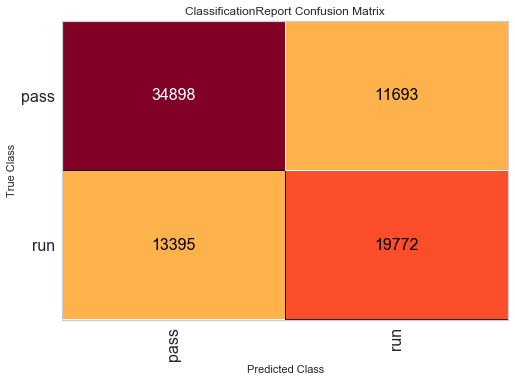

In [359]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(forrest, fontsize=16)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show(outpath='model_reports/forrest_cm.svg')

In [275]:
# import xgboost as xgb
# XGB_model = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
# XGB_model.fit(X_train, y_train)
# XGB_model.score(X_test ,y_test)

# XGB_model_train_score = XGB_model.score(X_train, y_train)
# XGB_model_test_score = XGB_model.score(X_test, y_test)
# print(f"Training Data Score: {XGB_model_train_score}")
# print(f"Testing Data Score: {XGB_model_test_score}")

Training Data Score: 0.6803734646199111
Testing Data Score: 0.6795180420772838


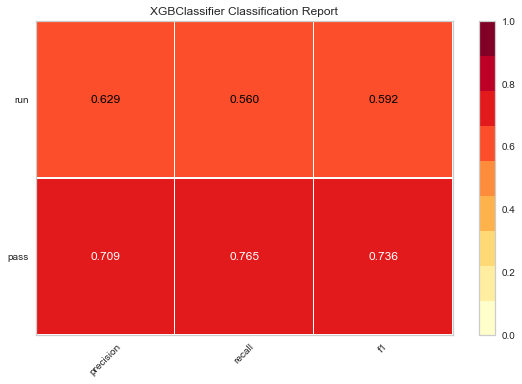

In [319]:
# XGBoost
XGb = ClassificationReport(XGB_model)
XGb.fit(X_train, y_train)
XGb.score(X_test, y_test)
XGb.show(outpath='model_reports/xgb.svg')

In [ ]:
####################################
#          Balancing dataset       #
####################################

In [339]:
# applying SMOTE to our data and checking the class counts
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(X_resampled.shape)
print(y_resampled.shape)


pt = PowerTransformer()
pt.fit(X_resampled)
X_resampled_transformed = pt.transform(X_resampled)
print(sorted(Counter(y_resampled).items()))

print(X_resampled_transformed.shape)
print(y_resampled.shape)
collections.Counter(y_resampled)


(372726, 15)
(372726,)
[('pass', 186363), ('run', 186363)]
(372726, 15)
(372726,)


In [344]:
# Splitting resampled data into training and testing
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, random_state=42)

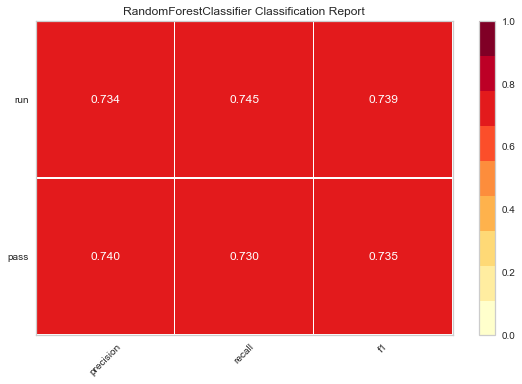

In [345]:
# Random Forrest
res_forrest = ClassificationReport(RandomForestClassifier(n_estimators=300))
res_forrest.fit(X_train_resampled, y_train_resampled)
res_forrest.score(X_test_resampled, y_test_resampled)
res_forrest.show(outpath='model_reports/forrest_resampled.svg')

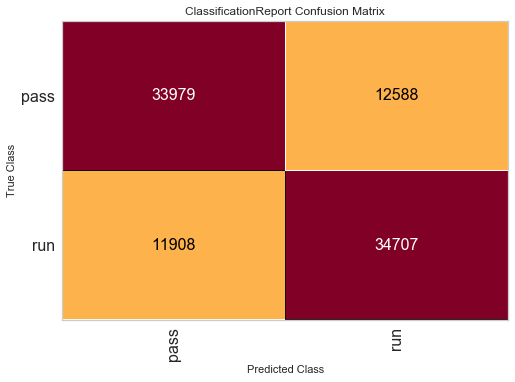

In [360]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(res_forrest, fontsize=16)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_resampled, y_train_resampled)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_resampled, y_test_resampled)

# How did we do?
cm.show(outpath='model_reports/forrest_resampled_cm.svg')


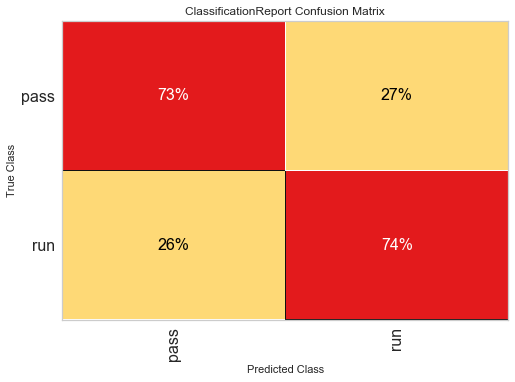

In [361]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(res_forrest, percent=True, fontsize=16)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_resampled, y_train_resampled)

# Creates the confusion_matrix from scikit-learn.
cm.score(X_test_resampled, y_test_resampled)

# Performance?
cm.show(outpath='model_reports/forrest_resampled_cm_percent.svg')

In [ ]:
print(X_resampled.shape)
print(y_resampled.shape)

In [ ]:
################################
# SELECTING IMPORTANT FEATURES #
################################

In [ ]:
rfc = RandomForestClassifier(random_state=100)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_resampled, y_resampled)

print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.savefig('plots/RFECV_resampled.png', dpi=600)
plt.show()


In [ ]:
print(np.where(rfecv.support_ == False)[0])

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=20, pad=20)
plt.xlabel('Number of features selected', fontsize=16, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=16, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=2)
plt.tight_layout()
plt.savefig('plots/RFECV.png', dpi=600)
plt.show()

In [ ]:
rfecv_plot = go.Figure(go.Scatter(
    x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    y=rfecv.grid_scores_
))

rfecv_plot.update_layout(
    title_text="Recursive Feature Elimination with Cross-Validation",
    xaxis_title="Number of Features Selected",
    yaxis_title="% Correct Classification",
)

# rfecv_plot.update_layout(
#     legend=go.layout.Legend(
#         x=0,
#         y=1,
#         traceorder="normal",
#         font=dict(
#             family="Avenir",
#             size=18,
#             color="black"
#         ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
#     )
# )
# fig.show(renderer="iframe", width=1200, height=800)
py.plot(rfecv_plot, filename = 'rfecv_plot', auto_open=False)

In [ ]:
non_impotant_features = np.where(rfecv.support_ == False)[0]
print(non_impotant_features)

In [ ]:
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_


In [ ]:
dset = dset.sort_values(by='importance', ascending=False)
dset.head(8)

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
ax.tick_params(labelsize=14)
plt.title('RFECV - Feature Importances', fontsize=20, pad=20)
plt.xlabel('Importance', fontsize=16, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 18)
plt.tight_layout()
plt.savefig('plots/important_features.png', dpi=600)
plt.show()

In [ ]:
# fig = go.Figure()

rfecv_features = go.Figure(data=go.Bar(
            x=dset['importance'],
            y=dset['attr'],
            marker=dict(
                color='rgba(8,80,111,100)'),
            orientation='h')
               )

rfecv_features.update_layout(
    title_text="RFECV - Feature Importances",
    xaxis_title="Importance Score",
)

rfecv_features.show(renderer="iframe", width=1200, height=800)
py.plot(rfecv_features, filename = 'rfecv_features', auto_open=False)

In [ ]:
#################################################################
# Saving selected dataset after removing non-important features
X_selected = X.copy()
X_selected.to_csv('X_selected.csv', index=False)
#################################################################
# Saving selected targets to match naming structure
y_selected = y.copy()
y_selected.to_csv('y_selected.csv', header=True, index=False)

In [ ]:
# Visualizing feature importance on final dataset
from yellowbrick.features import ParallelCoordinates
from yellowbrick.datasets import load_occupancy

# Load the classification data set
X_resampled, y_resampled = load_occupancy()

# Specify the features of interest and the classes of the target
features = ['yard_line', 'half_sec', 'game_sec', 'humidity', 'down', 'temp', 'score_diff', 'ydstogo']
classes = ['pass', 'run']

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='standard', sample=0.05, shuffle=True,
)

# Fit the visualizer and display it
visualizer.fit_transform(X_selected, y_selected)
visualizer.show(outpath='plots/ParallelCoordinates.png', dpi=600)

#### SUMMARY

1. Target classes were balanced for equal sampling of pass and run
2. Feature set was reduced from 15 to 8 using RFECV method on balanced data
3. Renamed new feature and target datasets as X_selected and y_selected 

*Note: X_selected and y_selected are not balanced*

In [ ]:
# X.dtypes

In [ ]:
# # Converting some down and qtr features to categorical
# X.down = X.down.astype(str)
# X.qtr = X.qtr.astype(str)

In [ ]:
# X.dtypes

In [ ]:
# # Encoding categorical features
# # Categorical boolean mask
# categorical_feature_mask = X.dtypes==object
# # filter categorical columns using mask and turn it into a list
# categorical_cols = X.columns[categorical_feature_mask].tolist()
# categorical_cols

In [ ]:
# # Instantiate labelencoder object
# le = LabelEncoder()
# # Apply le on categorical feature columns
# X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
# X[categorical_cols].head(10)

In [ ]:
# # Instantiate OneHotEncoder
# ohe = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False ) 
# # categorical_features = boolean mask for categorical columns
# # sparse = False output an array not sparse matrix

In [ ]:
# # apply OneHotEncoder on categorical feature columns
# X_ohe = ohe.fit_transform(X) # It returns an numpy array

In [ ]:
# X_ohe

In [ ]:
# rfc = RandomForestClassifier(random_state=100)
# rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
# rfecv.fit(X_ohe, y)

# print('Optimal number of features: {}'.format(rfecv.n_features_))

# plt.figure(figsize=(16, 9))
# plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
# plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
# plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
# plt.savefig('plots/RFECV.png', dpi=600)
# plt.show()

In [ ]:
# print(np.where(rfecv.support_ == False)[0])

In [ ]:
# rfecv.estimator_.feature_importances_

In [ ]:
# X.columns

In [ ]:
# dset = pd.DataFrame()
# dset['attr'] = X_ohe.columns
# dset['importance'] = rfecv.estimator_.feature_importances_

# # dset = dset.sort_values(by='importance', ascending=False)
# # dset.head()

In [ ]:
# plt.figure(figsize=(16, 14))
# plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
# plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
# plt.xlabel('Importance', fontsize=14, labelpad=20)
# plt.savefig('plots/important_features.png', dpi=600)
# plt.show()

In [ ]:
# transformed = np.cbrt(play_by_play.precipitation)

In [ ]:
# transformed